# Preprocessing Training Data

Another issue with Ground Truth masks is that some images, although not exactly the same, were taken close together and share an overlapping region. Often this means that a certain grain might be present in two separate images, and appear in one ground truth mask but not the other. Therefore, images must be cross-checked to see if they share a region, and then the overlapping region of one mask should be added to the other, and vice-versa, to make sure that grains are labelled correctly.

## To Do
1. Images will only share regions if they are from the same patient, so get list of patients.
1. Work out a method to check for overlap between images of a given patient.
1. Add shared region of masks to eachother and overwrite the mask file.

In [26]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import cv2
import sys
from PIL import Image
from tqdm import tqdm

sys.path.append('../src')
from utils import return_image_and_mask, return_image, return_mask, plot_image_and_mask

In [27]:
!ls ../data/

best_model_test_postproc_tiff   test_dataset
classification_labels_sub2.xlsx training_dataset
data.md                         validation_dataset
overlaid_mask_edges


In [28]:
DATA_DIR = '../data'

In [29]:
# Get full image path by adding filename to base path

# Get the paths
train_paths = np.array([os.path.relpath(i, DATA_DIR).split('.')[0] for i in glob.glob(f'{DATA_DIR}/training_dataset/**/*.jpg')])
val_paths = np.array([os.path.relpath(i, DATA_DIR).split('.')[0] for i in glob.glob(f'{DATA_DIR}/validation_dataset/**/*.jpg')])

print(f"Train length: {len(train_paths)}")
print(f"Val length: {len(val_paths)}")

Train length: 537
Val length: 87


In [30]:
# Sort paths to make sorting by patient easier
train_paths.sort()
val_paths.sort()

In [31]:
idx = 0
print(train_paths[idx:idx+10])

['training_dataset/BM/BM10_1' 'training_dataset/BM/BM10_2'
 'training_dataset/BM/BM11_1' 'training_dataset/BM/BM11_2'
 'training_dataset/BM/BM11_3' 'training_dataset/BM/BM11_4'
 'training_dataset/BM/BM11_5' 'training_dataset/BM/BM11_7'
 'training_dataset/BM/BM13_1' 'training_dataset/BM/BM13_2']


In [32]:
# Function to split path and return only the patient code (e.g. BM10)
def get_patient_id(path):
    
    # First take final part of the path, then take everything before the underscore
    patient_id = path.split('/')[2].split('_')[0]
    return patient_id

In [33]:
get_patient_id(train_paths[0])

'BM10'

In [34]:
train_patient_ids = list(set([get_patient_id(path) for path in train_paths]))
val_patient_ids = list(set([get_patient_id(path) for path in val_paths]))

In [44]:
len(val_patient_ids)

23

In [36]:
train_patient_ids[:20]

['BM13',
 'BM66',
 'FM21',
 'FM72',
 'FM47',
 'FM18',
 'FM22',
 'FM89',
 'FM80',
 'BM15',
 'FM57',
 'BM60',
 'BM38',
 'BM55',
 'BM49',
 'FM54',
 'FM24',
 'BM17',
 'BM47',
 'BM5']

In [37]:
# For a given patient, get all image paths
def get_patient_paths(paths, patient_id):
    patient_paths = [path for path in paths if patient_id in path]
    return patient_paths

PATIENT: FM57
training_dataset/FM/FM57_1


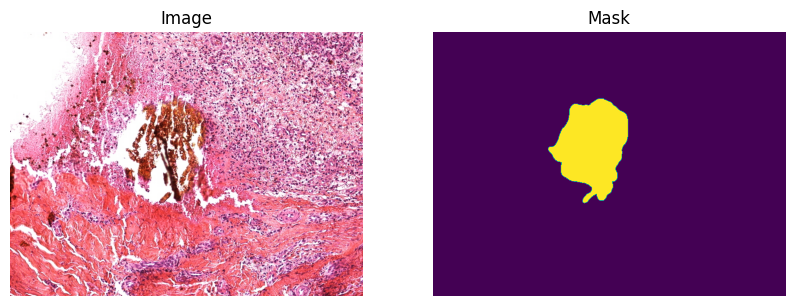

training_dataset/FM/FM57_2


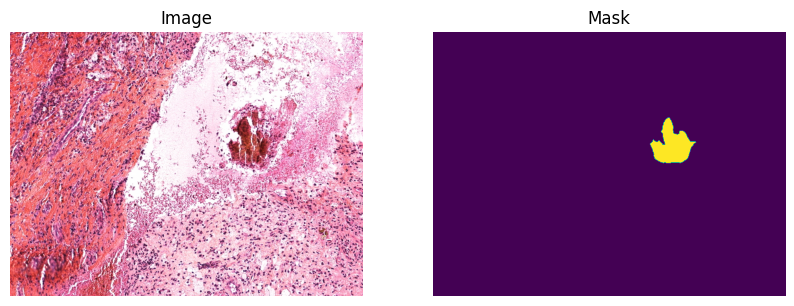

In [38]:
patient_id = train_patient_ids[10]
print(f'PATIENT: {patient_id}')
patient_paths = get_patient_paths(train_paths, patient_id)
for path in patient_paths:
    print(path)
    plot_image_and_mask(path)

In [47]:
# Function to match features of two images
# To be used as part of process to check if two images share an overlapping region
def detect_and_match_features(image1, image2):
    # Convert images to grayscale
    gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)
    
    # Detect ORB features and compute descriptors
    orb = cv2.ORB_create()
    keypoints1, descriptors1 = orb.detectAndCompute(gray1, None)
    keypoints2, descriptors2 = orb.detectAndCompute(gray2, None)
    
    # Match descriptors using BFMatcher
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(descriptors1, descriptors2)
    
    # Sort matches by distance
    matches = sorted(matches, key=lambda x: x.distance)
    
    return keypoints1, keypoints2, matches

In [48]:
# After keypoints and matches of two images have been calculated,
# this function takes the mean of the top 10 match translations 
def estimate_translation(keypoints1, keypoints2, matches):
    
    # Calculate the translation vector
    translations = []

    for match in matches[:10]:
            pt1 = keypoints1[match.queryIdx].pt
            pt2 = keypoints2[match.trainIdx].pt
            translations.append((pt2[0] - pt1[0], pt2[1] - pt1[1]))

    translations = np.array(translations)
    
    median_translation = np.rint(np.median(translations, axis=0))

    return median_translation

# Function to apply x-y translation to an image
def translate_image(image, translation):

    rows, cols = image.shape[:2]
    translation = (-translation[0], -translation[1])
    translation_matrix = np.float32([[1, 0, translation[0]], [0, 1, translation[1]]])
    translated_image = cv2.warpAffine(image, translation_matrix, (cols, rows))

    return translated_image

In [49]:
# Once an image has been translated, find the span of the nonzero part (the overlap part)
def find_overlap_bbox(image):

    # Find coordinates of all non-zero pixels
    coords = cv2.findNonZero(image[...,0])
    
    # Calculate the bounding box of the non-zero region
    x, y, w, h = cv2.boundingRect(coords)
    min_x, min_y, max_x, max_y = x, y, x + w, y + h

    return min_x, min_y, max_x, max_y

In [59]:
## VISUALISATION FUNCTIONS

# Plot to show matched features between two images
def visualize_matches(image1, image2, keypoints1, keypoints2, matches):
    matched_image = cv2.drawMatches(image1, keypoints1, image2, keypoints2, matches[:10], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    plt.figure(figsize=(15, 10))
    #plt.title('Matched Features')
    plt.imshow(matched_image)
    plt.axis('off')
    plt.show()

# Plot to show images before and after translation
def visualize_translation(image1, image2, translated_image2):
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.title('Original Image 1')
    plt.imshow(image1)
    
    plt.subplot(1, 3, 2)
    plt.title('Original Image 2')
    plt.imshow(image2)
    
    plt.subplot(1, 3, 3)
    plt.title('Translated Image 2')
    plt.imshow(translated_image2)
    
    plt.show()

# Plot to show the difference between the first image and the translated second image
def visualize_difference(image1, translated_image2):
    gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(translated_image2, cv2.COLOR_BGR2GRAY)
    difference = cv2.absdiff(gray1, gray2)
    
    plt.figure(figsize=(10, 5))
    plt.title('Difference Image')
    plt.imshow(difference, cmap='hot')
    plt.show()

In [76]:
# OVERLAP FUNCTION
# After matching features and getting a translation, the second image is translated to line up with the first.
# A bounding box of the matching region is then taken of both images, and the difference is taken.
# If the images truly do share a region, this difference is essentially zero (do blur of both before to account for small mis-alignment).

def check_overlap(image1, image2, visualize=True):

    # Detect and match features
    keypoints1, keypoints2, matches = detect_and_match_features(image1, image2)
    
    # Estimate translation
    translation = estimate_translation(keypoints1, keypoints2, matches)
    
    # Translate the second image
    translated_image2 = translate_image(image2, translation)
    
    # Convert images to grayscale
    gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(translated_image2, cv2.COLOR_BGR2GRAY)

    # Crop both to matching region
    xl,yl,xh,yh = find_overlap_bbox(translated_image2)
    crop1 = gray1[yl:yh,xl:xh]
    crop2 = gray2[yl:yh,xl:xh]

    # Gaussian Blur before measuring difference to reduce alignment error
    blurred_crop1 = cv2.GaussianBlur(crop1, (11, 11), 0)
    blurred_crop2 = cv2.GaussianBlur(crop2, (11, 11), 0)
    
    # Compute absolute difference between images
    diff = cv2.absdiff(blurred_crop1, blurred_crop2)

    # Threshold the difference image
    threshold_val = 40
    _, thresh = cv2.threshold(diff, threshold_val, 255, cv2.THRESH_BINARY)

    if visualize:
        # Visualize matched features
        visualize_matches(image1, image2, keypoints1, keypoints2, matches)

        # Visualize translation result
        visualize_translation(image1, image2, translated_image2)

        plt.imshow(translated_image2)
        plt.axis('off')
        plt.tight_layout()
        plt.show()

        # Visualise difference between matching areas
        #plt.title('Difference')
        plt.imshow(diff, cmap='hot')
        plt.axis('off')
        plt.show()

        # And when threshold is applied
        plt.title(f'thresholded at {threshold_val}')
        plt.imshow(thresh)
        plt.show()

    # Calculate percentage of overlap
    overlap = np.count_nonzero(thresh == 0) / np.size(thresh)

    return overlap, translation

### Example of matching two overlapping images

Bear in mind that the masks have already been overwritten here

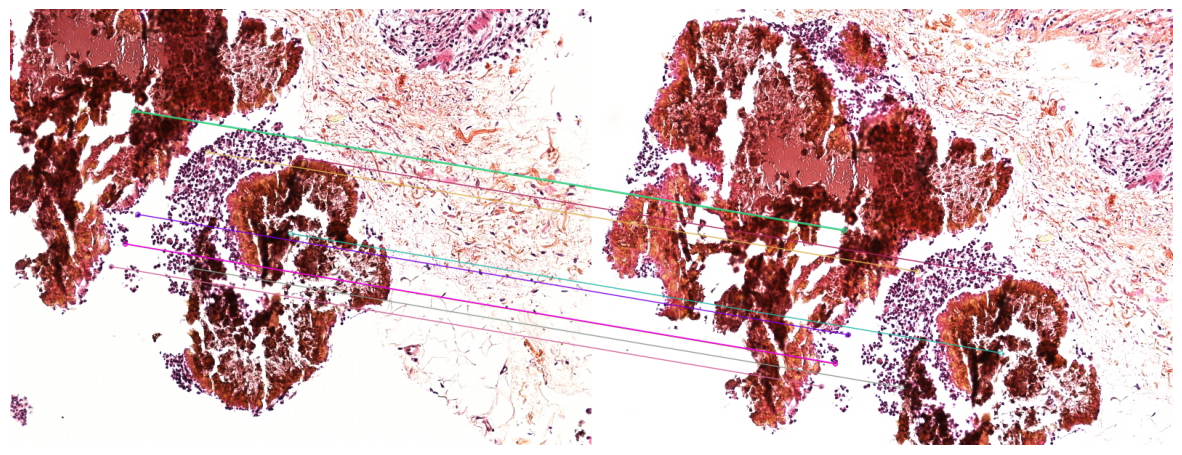

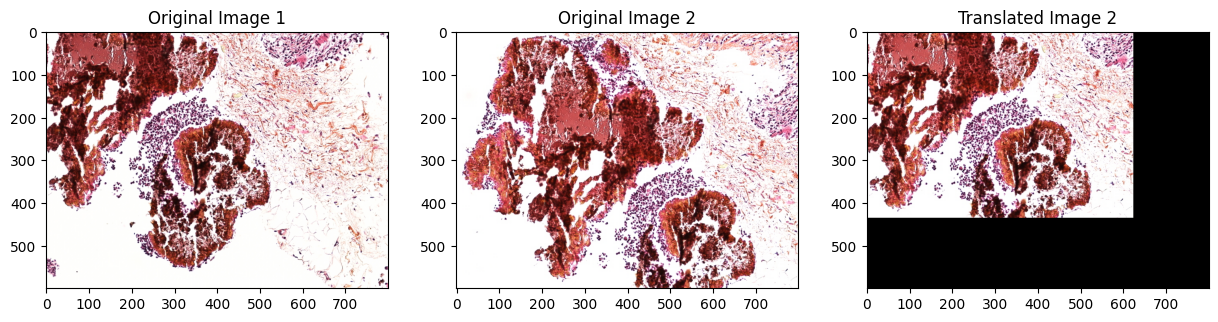

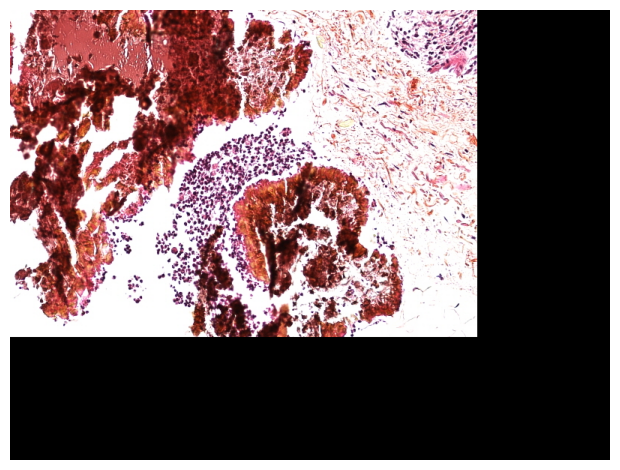

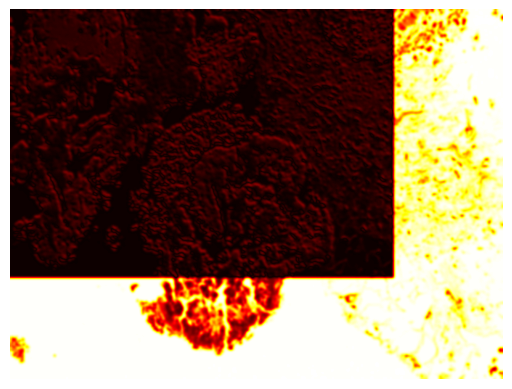

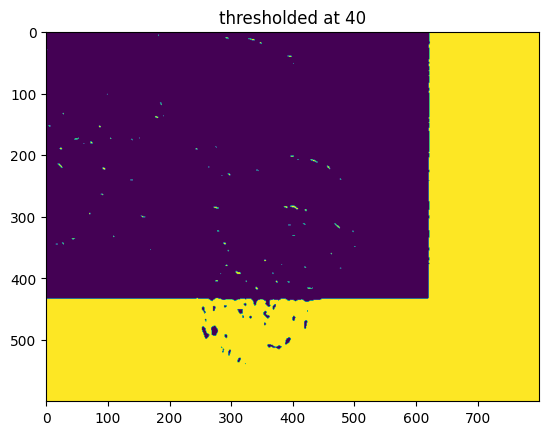

(0.5634125, array([177., 164.]))

In [69]:
# Load images
image1, mask1 = return_image_and_mask(DATA_DIR, 'training_dataset/FM/FM85_2')
image2, mask2 = return_image_and_mask(DATA_DIR, 'training_dataset/FM/FM85_3')

check_overlap(image1, image2)

FM85 (1/89)
['training_dataset/FM/FM85_1', 'training_dataset/FM/FM85_2', 'training_dataset/FM/FM85_3', 'training_dataset/FM/FM85_4', 'training_dataset/FM/FM85_5', 'training_dataset/FM/FM85_6']


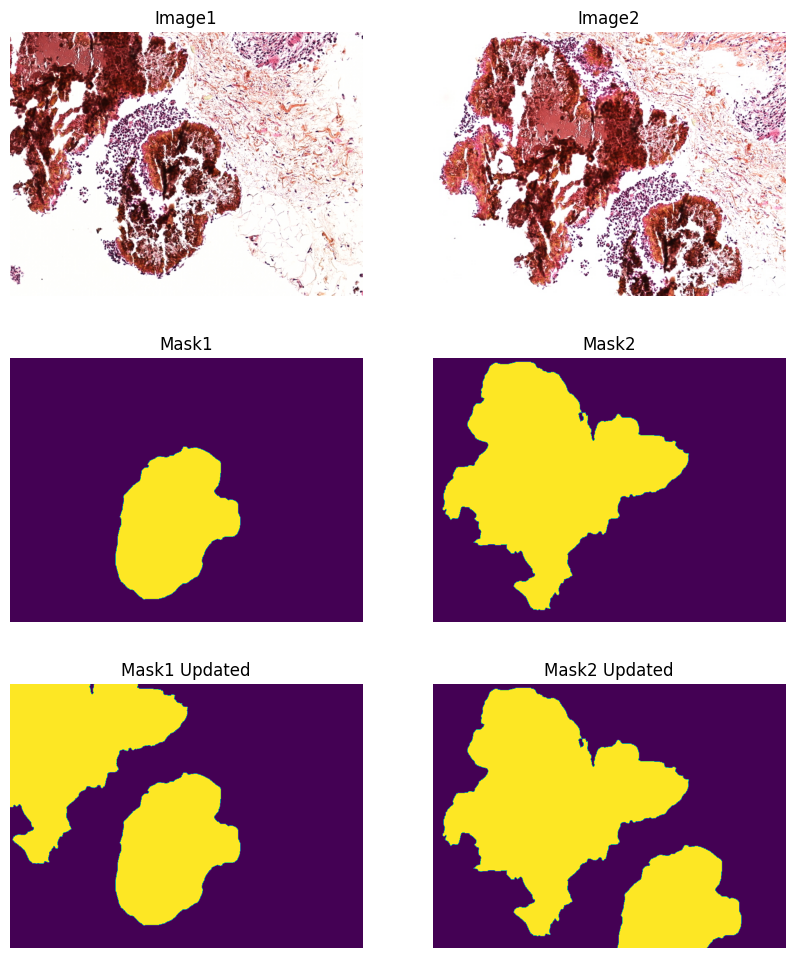

In [78]:
# If the overlap is greater than a certain threshold, shift the masks in the same way and add to each other.
from itertools import combinations

# cycle through patients
for i, patient in enumerate(['FM85']):
    print(f'{patient} ({i+1}/{len(train_patient_ids)})')
    patient_paths = get_patient_paths(train_paths, patient)
    print(patient_paths)

    # cycle through path combinations
    for path1, path2 in combinations(patient_paths, 2):

        # Load images and masks
        image1, mask1 = return_image_and_mask(DATA_DIR, path1)
        image2, mask2 = return_image_and_mask(DATA_DIR, path2)
        
        # Check overlap
        overlap, translation = check_overlap(image1, image2, visualize=False)

        # If the overlap is sufficient
        if overlap > 0.9:

            # Translate mask2 in same way
            translated_mask2 = translate_image(mask2, translation)

            # Translate mask1 in opposite way
            translated_mask1 = translate_image(mask1, (-translation[0],-translation[1]))

            # Add to mask1
            updated_mask1 = mask1 + translated_mask2
            updated_mask1 = np.clip(updated_mask1, 0, 1)

            # Add to mask2
            updated_mask2 = mask2 + translated_mask1
            updated_mask2 = np.clip(updated_mask2, 0, 1)

            # Overwrite mask1 and mask2 files 
            #updated_mask1_img = Image.fromarray(updated_mask1)
            #updated_mask2_img = Image.fromarray(updated_mask2)
    
            # Save the single-channel image, overwriting the original file
            #updated_mask1_img.save(DATA_DIR + '/' + path1 + '_mask.tif')
            #updated_mask2_img.save(DATA_DIR + '/' + path2 + '_mask.tif')

            #print(f'Mask at {path1} updated')

            fig, ax = plt.subplots(3, 2, figsize=(10, 12))

            ax[0][0].imshow(image1)
            ax[0][0].set_title('Image1')
            ax[0][0].axis('off')

            ax[0][1].imshow(image2)
            ax[0][1].set_title('Image2')
            ax[0][1].axis('off')

            ax[1][0].imshow(mask1)
            ax[1][0].set_title('Mask1')
            ax[1][0].axis('off')

            ax[1][1].imshow(mask2)
            ax[1][1].set_title('Mask2')
            ax[1][1].axis('off')

            ax[2][0].imshow(updated_mask1)
            ax[2][0].set_title('Mask1 Updated')
            ax[2][0].axis('off')

            ax[2][1].imshow(updated_mask2)
            ax[2][1].set_title('Mask2 Updated')
            ax[2][1].axis('off')

            plt.show()

            updated_mask1 = updated_mask1 * 255

            # Convert the numpy array to a PIL Image and save as JPG
            updated_mask1_image = Image.fromarray(updated_mask1)
            updated_mask1_image.save(f'example_updated_mask1.jpg', format='JPEG')

            updated_mask2 = updated_mask2 * 255

            # Convert the numpy array to a PIL Image and save as JPG
            updated_mask2_image = Image.fromarray(updated_mask2)
            updated_mask2_image.save(f'example_updated_mask2.jpg', format='JPEG')